In [1]:
!pip install ray=="2.4.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 85.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 kB 292.2 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from sklearn import metrics
import joblib

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from numpy.random import seed
seed(42)
import tensorflow as tf

In [5]:
import pytz
from datetime import timedelta, datetime
local_tz = pytz.timezone('America/Toronto') # Set local timezone for InfluxDB based times calculations
today=datetime.today().strftime('%Y-%m-%d')

#### Note: if you did not create new data for the model training, a sample is provided in this repository. 
#### To use it, ensure that in the next cell the instruction with the file name lt_results_2022-10-01.csv in it is executed and not the one using "today's" date

In [6]:
#data = pd.read_csv('lt_results_'+today+'.csv', index_col='DateTime', parse_dates=True, infer_datetime_format=True)
data = pd.read_csv('lt_results_2022-10-01.csv', index_col='DateTime', parse_dates=True, infer_datetime_format=True)

In [7]:
data.head()

,asyncResp,asyncRespThreads,cThreads,jacptQSize,jacptThreads,ltTargetSize,mean_tps,numConnections,req2xx,testDurationSeconds,timeoutSeconds
DateTime,,,,,,,,,,,
2022-09-28 15:25:25+00:00,True,21.0,277.0,1712.0,262.0,7.0,307.015227,31.0,50679.0,165.0,5.0
2022-09-28 15:34:42+00:00,True,30.0,173.0,2788.0,158.0,1.0,347.427221,35.0,146793.0,423.0,5.0
2022-09-28 15:47:10+00:00,True,28.0,125.0,1411.0,110.0,15.0,138.693699,14.0,84757.0,611.0,5.0
2022-09-28 15:56:35+00:00,True,14.0,115.0,1176.0,100.0,12.0,158.212165,16.0,68515.0,433.0,5.0
2022-09-28 16:01:09+00:00,True,30.0,226.0,2296.0,211.0,12.0,245.806605,25.0,34173.0,139.0,5.0


In [8]:
data = data.drop(columns=['req2xx', 'testDurationSeconds'])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data.mean_tps,
                                                    test_size=0.1,
                                                    random_state=0) # we are setting the seed here
X_train.shape, X_test.shape

((74, 9), (9, 9))

In [10]:
target_var = 'mean_tps'
X_train = X_train.drop(target_var, axis=1)
X_test = X_test.drop(target_var, axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
stdScaler = StandardScaler()
targetStdScaler = StandardScaler()

In [13]:
X_train_scaled = stdScaler.fit_transform(X_train.values)
y_train_scaled = targetStdScaler.fit_transform(y_train.values.reshape(-1,1))

In [14]:
X_test_scaled = stdScaler.transform(X_test.values)
y_test_scaled = targetStdScaler.transform(y_test.values.reshape(-1,1))

In [15]:
# Neural Nets imports
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [16]:
import ray

In [17]:
ray.shutdown()

In [18]:
ray_endpoint = 'ray://raycluster-complete-head-svc.demo.svc.cluster.local:10001'

In [19]:
import os

In [20]:
#Retrieve AWS access from the data connection attached to the workbench
aws_access_key_id = os.environ["AWS_ACCESS_KEY_ID"]
aws_secret_access_key = os.environ["AWS_SECRET_ACCESS_KEY"]
endpoint_url = os.environ["AWS_S3_ENDPOINT"]
bucket_name = os.environ["AWS_S3_BUCKET"]
region_name = os.environ["AWS_DEFAULT_REGION"]

In [21]:
ray.init(address=ray_endpoint)

Python version:,3.8.13
Ray version:,2.4.0
Dashboard:,http://10.131.0.75:8265


In [22]:
verboseLevel=0
validationSplit=0.2
batchSize=30
epochs=1000

In [23]:
# callback preparation
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=2,
                              verbose=verboseLevel,
                              mode='min',
                              min_lr=0.001)

In [24]:
inputSize = X_train_scaled.shape[1]
colList = ['HiddenLayers', 'R2Score', 'MAE', 'MSE', 'MAPE', 'H5FileName', 'TrainHistory', 'TrainPredictions']

In [25]:
target_loss = 'mae'
#loss = 'mse'
measure_metrics = ['mae', 'mse']
#measure_metrics = ['mae']

In [26]:
# This function is the reference for creating and training the models inside the Jupyter notebook pod. We will evaluate it against the Ray cluster distributed one
def createModel(testResultsFrame, layerSize, loops, target_loss, measure_metrics,
                y_train, X_train, y_test, X_test, targetScaler, labelSet):
    print(f'Creating model using layer size = {layerSize} on set = {labelSet}.\n')
    for i in range(loops):
        print(f'Training on {i} hidden layers\n')
        model = Sequential()
        model.add(Dense(layerSize, kernel_initializer='normal',
                        #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                        #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                        #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                        input_dim=inputSize, activation='relu'))
        for j in range(i):
            model.add(Dense(layerSize, 
                            #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                            #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                            kernel_initializer='normal', activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(1, kernel_initializer='normal', 
                        #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                        #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                        #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                        activation='linear'))

        optmzr=Adam(learning_rate=0.001)    
        model.compile(optimizer=optmzr, loss=target_loss, metrics=measure_metrics)

        model_h5_name = 'mlp_' + str(layerSize)+ '_' + str(i) + '_model_std_' + labelSet + '.h5'
        checkpoint_nn_std = ModelCheckpoint(model_h5_name,
                                 monitor='val_loss',
                                 verbose=verboseLevel,
                                 save_best_only=True,
                                 mode='min')
        callbacks_list_nn_std = [checkpoint_nn_std, reduce_lr]

        history_MLP_std = model.fit(X_train, y_train,
                                    batch_size=batchSize, 
                                    validation_split=validationSplit, 
                                    epochs=epochs, verbose=verboseLevel,
                                    callbacks=callbacks_list_nn_std)

        #reload the best model!
        model_new = load_model(model_h5_name)
        #Predict
        y_pred_scaled = model_new.predict(X_test)
        #Evaluate metrics
        y_pred = targetScaler.inverse_transform(y_pred_scaled)
        r2_score = metrics.r2_score(y_test, y_pred)
        mae = metrics.mean_absolute_error(y_test, y_pred)
        mse = metrics.mean_squared_error(y_test, y_pred)
        mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
        #store values
        row = [i, r2_score, mae, mse, mape, model_h5_name, history_MLP_std, y_pred]
        df = pd.DataFrame(np.array(row, dtype=object).reshape(1, len(colList)), columns=colList)
        testResultsFrame = testResultsFrame.append(df, ignore_index=True)

        tf.keras.backend.clear_session()
        del(model)
        del(model_new)
        
    return testResultsFrame


In [27]:
@ray.remote
def createRemoteModel(layerSize, loops, target_loss, measure_metrics,
                y_train, X_train, y_test, X_test, targetScaler, labelSet):
    print(f'Creating model using {loops} hidden layers of size = {layerSize} on set = {labelSet}.\n')
    model = Sequential()
    model.add(Dense(layerSize, kernel_initializer='normal',
                    #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                    #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                    #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                    input_dim=inputSize, activation='relu'))
    for j in range(loops):
        model.add(Dense(layerSize, 
                        #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                        #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                        #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                        kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal', 
                    #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                    #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                    #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                    activation='linear'))

    optmzr=Adam(learning_rate=0.001)    
    model.compile(optimizer=optmzr, loss=target_loss, metrics=measure_metrics)

    model_h5_name = 'mlp_' + str(layerSize)+ '_' + str(loops) + '_model_std_' + labelSet + '.h5'
    checkpoint_nn_std = ModelCheckpoint(model_h5_name,
                             monitor='val_loss',
                             verbose=verboseLevel,
                             save_best_only=True,
                             mode='min')
    callbacks_list_nn_std = [checkpoint_nn_std, reduce_lr]

    history_MLP_std = model.fit(X_train, y_train,
                                batch_size=batchSize, 
                                validation_split=validationSplit, 
                                epochs=epochs, verbose=verboseLevel,
                                callbacks=callbacks_list_nn_std)

    #reload the best model!
    model_new = load_model(model_h5_name)
    #Predict
    y_pred_scaled = model_new.predict(X_test)
    #Evaluate metrics
    y_pred = targetScaler.inverse_transform(y_pred_scaled)
    r2_score = metrics.r2_score(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    #store values
    row = [loops, r2_score, mae, mse, mape, model_h5_name, history_MLP_std, y_pred]
    #df = pd.DataFrame(np.array(row, dtype=object).reshape(1, len(colList)), columns=colList)
    #testResultsFrame = testResultsFrame.append(df, ignore_index=True)

    #tf.keras.backend.clear_session()
    #del(model)
    #del(model_new)
        
    #return testResultsFrame
    return row


In [28]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [29]:
%%time
testResDataFrame = pd.DataFrame(columns=colList)
layerSize = 64
loops = 15
testResDataFrame = createModel(testResDataFrame, layerSize, loops, 
                        target_loss, measure_metrics,
                        y_train_scaled, X_train_scaled,
                        y_test, X_test_scaled, 
                        targetStdScaler, 'all')


Creating model using layer size = 64 on set = all.

Training on 0 hidden layers

Training on 1 hidden layers

Training on 2 hidden layers

Training on 3 hidden layers

Training on 4 hidden layers

Training on 5 hidden layers

Training on 6 hidden layers

Training on 7 hidden layers

Training on 8 hidden layers

Training on 9 hidden layers

Training on 10 hidden layers

Training on 11 hidden layers

Training on 12 hidden layers

Training on 13 hidden layers

Training on 14 hidden layers

CPU times: user 7min 46s, sys: 1min 41s, total: 9min 28s
Wall time: 6min 28s


In [30]:
%%time

testResDataFrame2 = []
layerSize = 64
loops = 15


for i in range(loops):
    rowResult = createRemoteModel.remote(layerSize, i, 
                        target_loss, measure_metrics,
                        y_train_scaled, X_train_scaled,
                        y_test, X_test_scaled, 
                        targetStdScaler, 'all_ray')
    testResDataFrame2.append(rowResult)

ray.get(testResDataFrame2)

INFO:tensorflow:Assets written to: ram://7b17e9cb-8f99-45f9-bb5a-2ee95047654e/assets


(pid=222, ip=10.131.0.73) 2023-06-23 06:15:18.549775: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
(pid=222, ip=10.131.0.73) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=223, ip=10.131.0.74) 2023-06-23 06:15:18.618828: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
(pid=223, ip=10.131.0.74) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=222, ip=10.131.0.72) 2023-06-23 06:15:18.712378: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to u

(createRemoteModel pid=222, ip=10.131.0.73) Creating model using 10 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=222, ip=10.131.0.73) 
(createRemoteModel pid=223, ip=10.131.0.74) Creating model using 7 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=223, ip=10.131.0.74) 
(createRemoteModel pid=764) Creating model using 8 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=764) 
(createRemoteModel pid=222, ip=10.131.0.72) Creating model using 0 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=222, ip=10.131.0.72) 
(createRemoteModel pid=306, ip=10.131.0.74) Creating model using 12 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=306, ip=10.131.0.74) 
(createRemoteModel pid=267, ip=10.131.0.72) Creating model using 13 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=267, ip=10.131.0.72) 
(createRemoteModel pid=811) Creating model using 14 hidden layers of size = 64 on set =

(pid=223, ip=10.130.0.34) 2023-06-23 06:15:21.321295: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
(pid=223, ip=10.130.0.34) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=222, ip=10.130.0.35) 2023-06-23 06:15:21.321328: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
(pid=222, ip=10.130.0.35) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=222, ip=10.130.0.37) 2023-06-23 06:15:21.321676: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to u

(createRemoteModel pid=223, ip=10.130.0.34) Creating model using 6 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=223, ip=10.130.0.34) 
(createRemoteModel pid=222, ip=10.130.0.35) Creating model using 3 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=222, ip=10.130.0.35) 
(createRemoteModel pid=222, ip=10.130.0.36) Creating model using 1 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=222, ip=10.130.0.36) 
(createRemoteModel pid=222, ip=10.130.0.37) Creating model using 11 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=222, ip=10.130.0.37) 


(pid=223, ip=10.129.0.31) 2023-06-23 06:15:23.137845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
(pid=223, ip=10.129.0.31) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=222, ip=10.129.0.32) 2023-06-23 06:15:23.137845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
(pid=222, ip=10.129.0.32) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=223, ip=10.129.0.30) 2023-06-23 06:15:23.137845: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to u

(createRemoteModel pid=223, ip=10.129.0.31) Creating model using 2 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=223, ip=10.129.0.31) 
(createRemoteModel pid=223, ip=10.129.0.30) Creating model using 5 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=223, ip=10.129.0.30) 
(createRemoteModel pid=222, ip=10.129.0.32) Creating model using 4 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=222, ip=10.129.0.32) 
(createRemoteModel pid=223, ip=10.129.0.32) Creating model using 9 hidden layers of size = 64 on set = all_ray.
(createRemoteModel pid=223, ip=10.129.0.32) 


(createRemoteModel pid=222, ip=10.130.0.36) 2023-06-23 06:15:51.873221: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(createRemoteModel pid=223, ip=10.129.0.31) 2023-06-23 06:15:51.990886: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(createRemoteModel pid=223, ip=10.130.0.34) 2023-06-23 06:15:52.919607: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(createRemoteModel pid=222, ip=10.130.0.35) 2023-06-23 06:15:52.874083: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
(createRemoteModel pid=222, ip=10.131.0.73) 2023-06-23 06:15:53.357147: W tensorflow/python/util/util.cc:368

CPU times: user 10.8 s, sys: 1.91 s, total: 12.7 s
Wall time: 1min 41s


[[0,
  0.9979189332370854,
  3.201357151267991,
  17.346334758306053,
  0.016023215029345686,
  'mlp_64_0_model_std_all_ray.h5',
  array([[246.46606 ],
         [102.785446],
         [282.93906 ],
         [138.95897 ],
         [252.39532 ],
         [269.17694 ],
         [137.71901 ],
         [362.09006 ],
         [386.15445 ]], dtype=float32)],
 [1,
  0.9872695357621892,
  8.774762161346896,
  106.11235460242163,
  0.04788953661858722,
  'mlp_64_1_model_std_all_ray.h5',
  array([[234.69026],
         [ 92.00232],
         [283.46954],
         [136.34999],
         [250.66322],
         [264.86017],
         [123.3551 ],
         [363.48825],
         [372.16672]], dtype=float32)],
 [2,
  0.9936309350821128,
  5.687877199238149,
  53.08812486550087,
  0.02335564972245731,
  'mlp_64_2_model_std_all_ray.h5',
  array([[245.57648],
         [109.83488],
         [283.80768],
         [144.33456],
         [251.42294],
         [267.24954],
         [144.0393 ],
         [344.67432],

In [31]:
%%time

tResDF2 = ray.get(testResDataFrame2)

CPU times: user 7.44 s, sys: 821 ms, total: 8.26 s
Wall time: 31.7 s


As you can see the ray.get() is a blocking function so it waits until all the tasks for the current job on the ray cluster have completed (in our case the 15 models training).
This method then retrieves the results from the tasks and provides the final result. 
As you can see this takes about 32 seconds, and as the same instruction is present in the ray job cell which completed in 1 min 41s, we can deduct this time and see that the actual training time on the Ray cluster was 1min 9s. These values apply to the type of physical resources available in this cluster (your cluster results may differ).

In [32]:
df = pd.DataFrame(tResDF2, columns=colList)

In [33]:
df

,HiddenLayers,R2Score,MAE,MSE,MAPE,H5FileName,TrainHistory,TrainPredictions
0,0,0.997919,3.201357,17.346335,0.016023,mlp_64_0_model_std_all_ray.h5,<keras.callbacks.History object at 0x7f8f148a5...,"[[246.46606], [102.785446], [282.93906], [138...."
1,1,0.987270,8.774762,106.112355,0.047890,mlp_64_1_model_std_all_ray.h5,<keras.callbacks.History object at 0x7f8e643b3...,"[[234.69026], [92.00232], [283.46954], [136.34..."
2,2,0.993631,5.687877,53.088125,0.023356,mlp_64_2_model_std_all_ray.h5,<keras.callbacks.History object at 0x7f8e46a8e...,"[[245.57648], [109.83488], [283.80768], [144.3..."
3,3,0.996421,3.951608,29.831480,0.025028,mlp_64_3_model_std_all_ray.h5,<keras.callbacks.History object at 0x7f8e468b8...,"[[243.43571], [96.199554], [279.94604], [136.1..."
4,4,0.996911,3.520771,25.750100,0.023543,mlp_64_4_model_std_all_ray.h5,<keras.callbacks.History object at 0x7f8e46607...,"[[248.00893], [97.73375], [277.7014], [136.916..."
5,5,0.989341,8.858521,88.848544,0.043141,mlp_64_5_model_std_all_ray.h5,<keras.callbacks.History object at 0x7f8e46394...,"[[235.23106], [98.75009], [271.52127], [130.54..."
6,6,0.998126,3.071630,15.624222,0.017200,mlp_64_6_model_std_all_ray.h5,<keras.callbacks.History object at 0x7f8e460e0...,"[[245.95592], [103.3225], [277.23056], [134.45..."
7,7,0.993293,6.677309,55.907736,0.034643,mlp_64_7_model_std_all_ray.h5,<keras.callbacks.History object at 0x7f8e45de1...,"[[256.05005], [97.521484], [284.58133], [133.7..."
8,8,0.995494,5.545381,37.556738,0.031749,mlp_64_8_model_std_all_ray.h5,<keras.callbacks.History object at 0x7f8e45a88...,"[[249.1126], [97.497696], [282.6704], [132.664..."
9,9,0.995592,5.085335,36.738663,0.029405,mlp_64_9_model_std_all_ray.h5,<keras.callbacks.History object at 0x7f8e45771...,"[[247.29138], [100.823044], [275.3997], [129.9..."


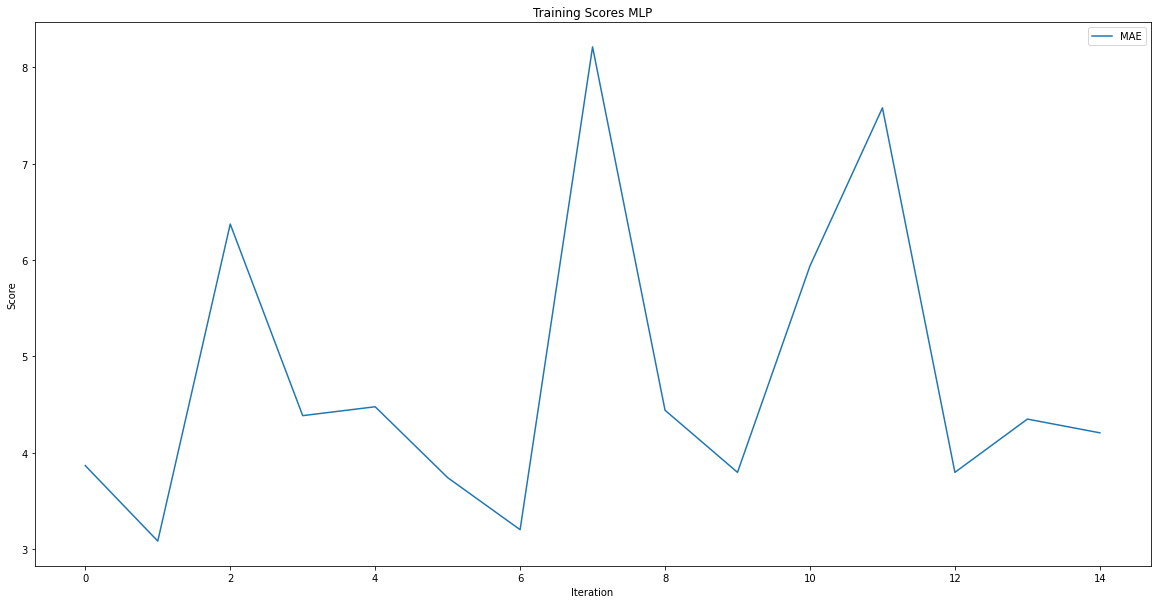

In [34]:
#Plot train vs validation
plt.figure(figsize=(20,10))
#plt.plot(testResDataFrame['R2Score'])
plt.plot(testResDataFrame['MAE'])
#plt.plot(testResDataFrame['MSE'])
plt.title('Training Scores MLP')
plt.ylabel('Score')
plt.xlabel('Iteration')
plt.legend(['MAE'], loc='upper right')
plt.show()

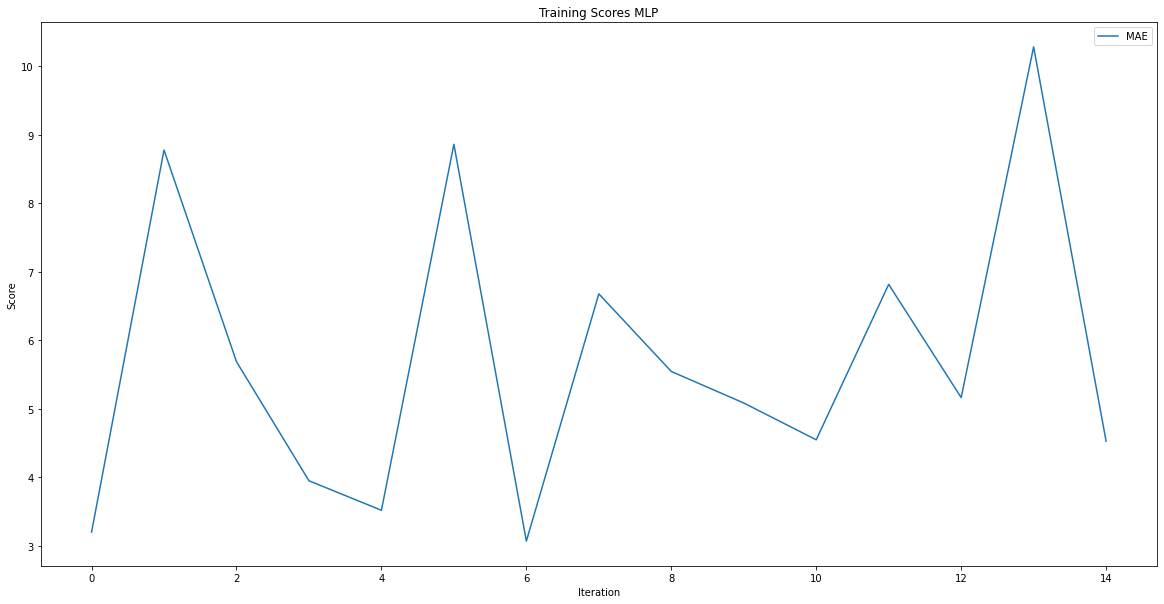

In [35]:
#Plot train vs validation
plt.figure(figsize=(20,10))
#plt.plot(df['R2Score'])
plt.plot(df['MAE'])
#plt.plot(df['MSE'])
plt.title('Training Scores MLP')
plt.ylabel('Score')
plt.xlabel('Iteration')
plt.legend(['MAE'], loc='upper right')
plt.show()

In [36]:
# Determine the IDX value where the MAE is smallest
minMaeIDX = testResDataFrame.loc[testResDataFrame['MAE']==testResDataFrame['MAE'].min()].index[0]

In [37]:
testResDataFrame.iloc[minMaeIDX]

HiddenLayers                                                        1
R2Score                                                       0.99846
MAE                                                          3.084108
MSE                                                         12.834597
MAPE                                                         0.017307
H5FileName                                  mlp_64_1_model_std_all.h5
TrainHistory        <keras.callbacks.History object at 0x7f8f0032f...
TrainPredictions    [[242.69926], [101.40457], [279.462], [140.068...
Name: 1, dtype: object

In [38]:
minMaeIDX_ray = df.loc[df['MAE']==df['MAE'].min()].index[0]

In [39]:
df.iloc[minMaeIDX_ray]

HiddenLayers                                                        6
R2Score                                                      0.998126
MAE                                                           3.07163
MSE                                                         15.624222
MAPE                                                           0.0172
H5FileName                              mlp_64_6_model_std_all_ray.h5
TrainHistory        <keras.callbacks.History object at 0x7f8e460e0...
TrainPredictions    [[245.95592], [103.3225], [277.23056], [134.45...
Name: 6, dtype: object

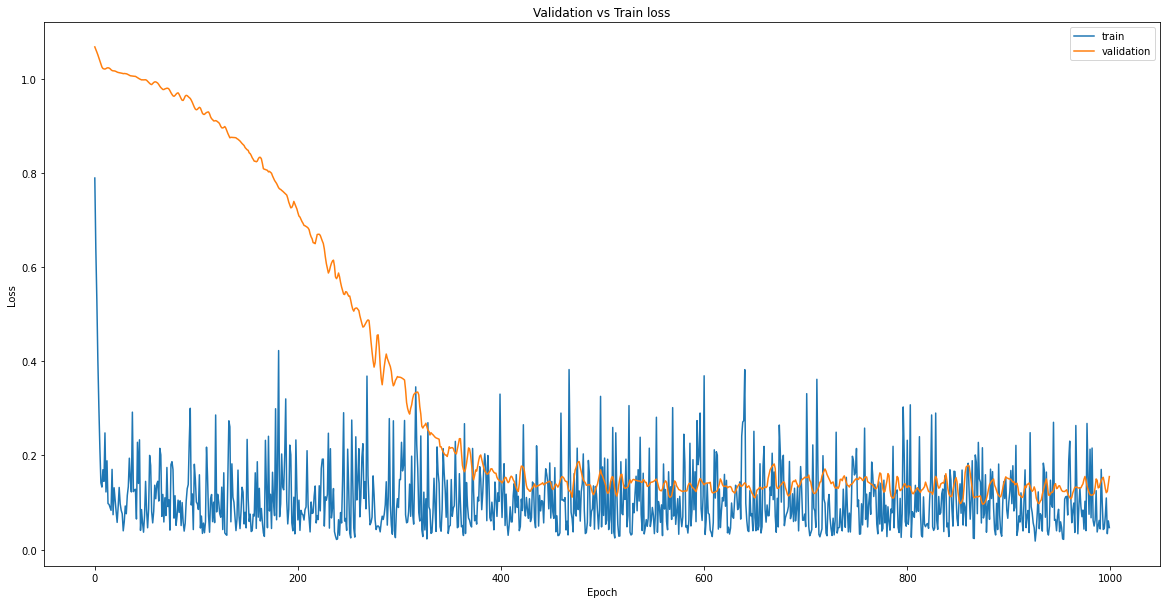

In [40]:
history_MLP = testResDataFrame['TrainHistory'][minMaeIDX]
#Plot train vs validation
plt.figure(figsize=(20,10))
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.title('Validation vs Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

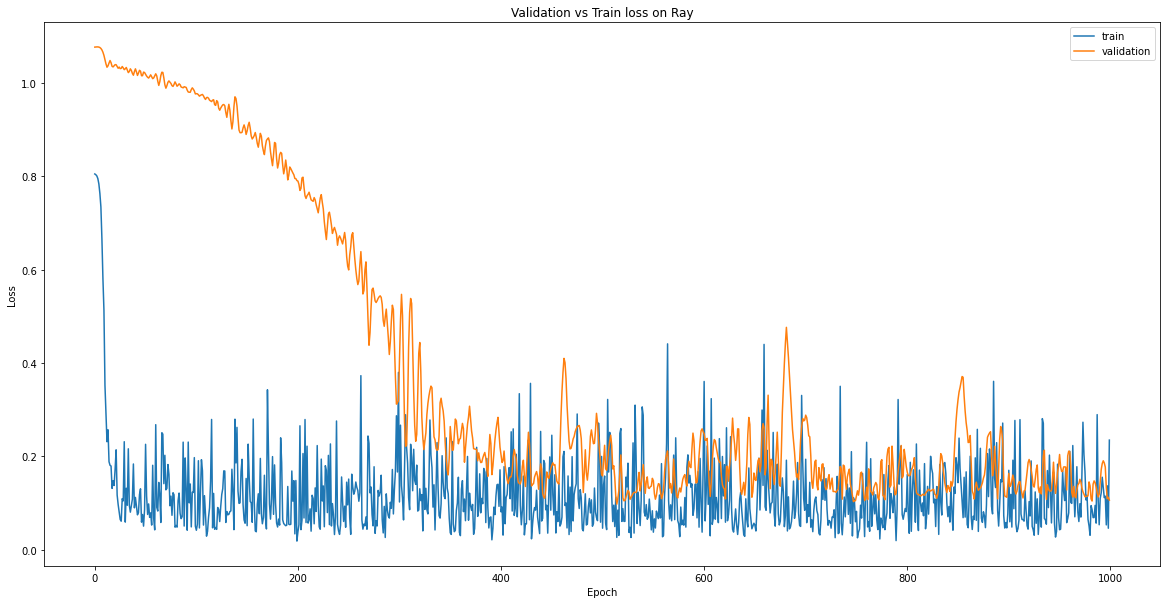

In [41]:
history_MLP = df['TrainHistory'][minMaeIDX_ray]
#Plot train vs validation
plt.figure(figsize=(20,10))
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.title('Validation vs Train loss on Ray')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

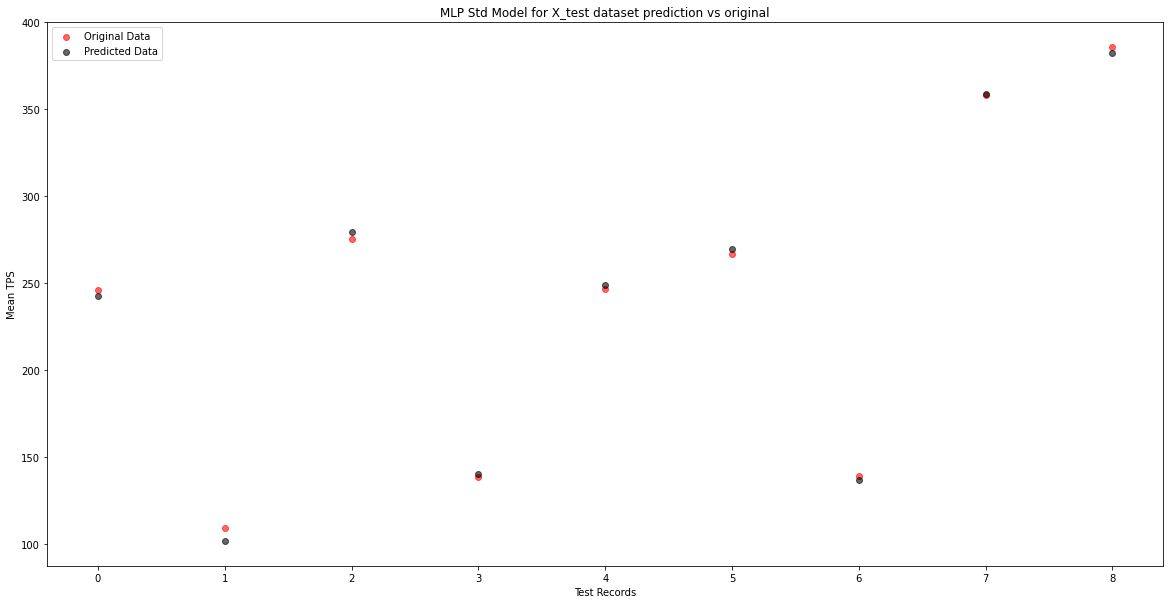

In [42]:
y_pred_MLP_std = testResDataFrame['TrainPredictions'][minMaeIDX]
# Plot prediction vs original
plt.figure(figsize=(20,10))
plt.scatter(range(y_test.shape[0]),y_test,label="Original Data", alpha=0.6, c='red')
plt.scatter(range(y_pred_MLP_std.shape[0]),y_pred_MLP_std,label="Predicted Data", 
            alpha=0.6, c='black')
plt.ylabel('Mean TPS')
plt.xlabel('Test Records')
plt.title('MLP Std Model for X_test dataset prediction vs original')
plt.legend()
plt.show()

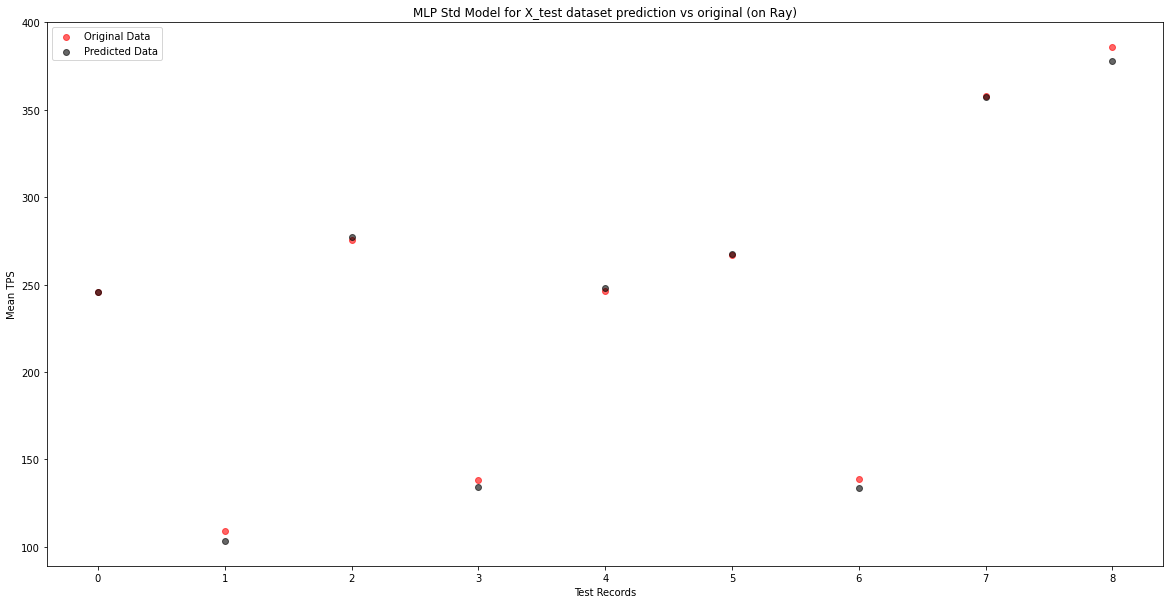

In [43]:
y_pred_MLP_std = df['TrainPredictions'][minMaeIDX_ray]
# Plot prediction vs original
plt.figure(figsize=(20,10))
plt.scatter(range(y_test.shape[0]),y_test,label="Original Data", alpha=0.6, c='red')
plt.scatter(range(y_pred_MLP_std.shape[0]),y_pred_MLP_std,label="Predicted Data", 
            alpha=0.6, c='black')
plt.ylabel('Mean TPS')
plt.xlabel('Test Records')
plt.title('MLP Std Model for X_test dataset prediction vs original (on Ray)')
plt.legend()
plt.show()

In [44]:
X_test.columns

Index(['asyncResp', 'asyncRespThreads', 'cThreads', 'jacptQSize',
       'jacptThreads', 'ltTargetSize', 'numConnections', 'timeoutSeconds'],
      dtype='object')

In [45]:
data.head(1)

,asyncResp,asyncRespThreads,cThreads,jacptQSize,jacptThreads,ltTargetSize,mean_tps,numConnections,timeoutSeconds
DateTime,,,,,,,,,
2022-09-28 15:25:25+00:00,True,21.0,277.0,1712.0,262.0,7.0,307.015227,31.0,5.0


In [46]:
record = [[True, 21, 277, 1712, 262, 7, 31, 5]]

In [47]:
test_rec = stdScaler.transform(record)

In [48]:
test_rec

array([[ 0.34815531, -0.16614866,  1.14391569, -0.53671704,  1.14391569,
        -0.29012346,  0.90504761,  0.30039875]])

In [49]:
test_model = load_model(testResDataFrame['H5FileName'][minMaeIDX])

In [50]:
test_pred = test_model.predict(test_rec)

In [51]:
test_pred

array([[0.9382158]], dtype=float32)

In [52]:
targetStdScaler.inverse_transform(test_pred)

array([[309.59528]], dtype=float32)

### Save the scalers for the inference calls

In [53]:
joblib.dump(targetStdScaler,'target_scaler.pkl')

['target_scaler.pkl']

In [54]:
joblib.dump(stdScaler,'standard_scaler.pkl')

['standard_scaler.pkl']

### Export to ONNX to run on the RHODS model server

In [55]:
!pip3 install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 154.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 320.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.7.4 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.23.3 which is incompatible.

[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [56]:
import tf2onnx

In [57]:
model_onnx, _ = tf2onnx.convert.from_keras(test_model, output_path='tf_mlasp.onnx')

### Upload model to S3 bucket

In [58]:
import boto3
import botocore

In [59]:
#S3 AWS client
#s3_aws = boto3.client(service_name = 's3',
#                      aws_access_key_id = aws_access_key_id,
#                      aws_secret_access_key = aws_secret_access_key,
#                      region_name = region_name)

In [60]:
#S3 Rados GW client
s3_rados = boto3.client(service_name = 's3',
                      aws_access_key_id = aws_access_key_id,
                      aws_secret_access_key = aws_secret_access_key,
                      region_name = 'default',
                      endpoint_url = endpoint_url,
                      config = botocore.client.Config(signature_version = 's3'))

In [61]:
s3_rados.upload_file('tf_mlasp.onnx', bucket_name, 'models/tf_mlasp.onnx')

In [62]:
ray.shutdown()